In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt
import altair as alt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    mean_absolute_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

from prettytable import PrettyTable, TableStyle
from scipy.stats import skew

# Data Analysis Begins

- Load data

In [4]:
def load_data(option: str = "1985-2023") -> pd.DataFrame:
    """
    Load a dataset based on the specified time range.

    This function reads an Excel file containing the dataset for the specified time range
    and returns it as a pandas DataFrame. Two options are currently available:
    "1985-2023" or "2010-2023".

    Args:
        option (str, optional): A string indicating the time range for the dataset.
            Defaults to "1985-2023".
            - "1985-2023": Loads data from 'tentative_final_with_NaN.xlsx'.
            - "2010-2023": Loads data from 'tentative_final.xlsx'.

    Returns:
        pd.DataFrame: A DataFrame containing the dataset for the specified time range.

    Raises:
        FileNotFoundError: If the specified Excel file is not found.
        ValueError: If an invalid option is provided.

    Example:
        >>> df = load_data(option="2010-2023")
        >>> print(df.head())
    """
    df = pd.DataFrame()
    if option == "1985-2023":
        df = pd.read_excel("../data/tentative_final_with_NaN.xlsx")
    elif option == "2010-2023":
        df = pd.read_excel("../data/tentative_final.xlsx")
    else:
        raise ValueError("Invalid option. Choose either '1985-2023' or '2010-2023'.")
    return df

### Load and view data

In [5]:
tentative_df = load_data(option="1985-2023")
tentative_df

,County,Year,Population,crime_rate,clearance_rate,population_density,unemployment_rate,adjusted_income,poverty_rate,rent_burden,...,adj_prison_budget,median_house_value,house_affordability,Category,Category_encoded,Category_Rural,Category_Suburban,Category_Urban,uninsured_rate,high_school_rate
0,Alameda,1985,1185500,0.009809,0.004580,1606.368564,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
1,Alameda,1986,1206900,0.010353,0.004615,1635.365854,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
2,Alameda,1987,1220600,0.009588,0.005164,1653.929539,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
3,Alameda,1988,1242300,0.008825,0.004595,1683.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
4,Alameda,1989,1261200,0.008375,0.004163,1708.943089,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Urban,2,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,Yuba,2019,79619,0.004095,0.001683,126.379365,6.2,201.708250,15.2,41.5,...,1.290150,257100.0,4.541841,Rural,0,1,0,0,0.072427,82.3
2258,Yuba,2020,81178,0.004977,0.001983,128.853968,10.6,197.248655,16.3,37.5,...,1.278197,273600.0,4.861580,Rural,0,1,0,0,0.071218,82.2
2259,Yuba,2021,82091,0.004312,0.001815,130.303175,8.4,204.337343,15.6,39.3,...,1.338206,286000.0,4.706734,Rural,0,1,0,0,0.070699,81.2
2260,Yuba,2022,82563,0.003379,0.001466,131.052381,5.6,199.314588,14.9,39.5,...,1.309347,350600.0,5.510326,Rural,0,1,0,0,0.069229,82.7


In [6]:
def add_new_features(df: pd.DataFrame, features: dict) -> pd.DataFrame:
    """
    Add new features (columns) to a given DataFrame.

    This function takes an existing DataFrame and a dictionary of features,
    where keys are column names and values are the data to be added. It creates
    a copy of the original DataFrame, adds the new features to it, and returns
    the updated DataFrame.

    Args:
        df (pd.DataFrame): The original DataFrame to which new features will be added.
        features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column (as lists or arrays).

    Returns:
        pd.DataFrame: A new DataFrame with the added features.

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> new_df = add_new_features(df, features)
        >>> print(new_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
    """
    new_df = df.copy()
    for key, val in features.items():
        new_df[key] = val
    return new_df

In [7]:
def choose_dataframe(df, option, new_features: dict) -> tuple[pd.DataFrame, list]:
    """
    Choose between the original DataFrame or an updated version with new features.

    This function takes an existing DataFrame, an option specifying whether to add
    new features, and a dictionary of new features. If the option is "new", the function
    adds the new features to a copy of the DataFrame and returns it, along with a list
    of the new feature names. If the option is not "new", it returns the original DataFrame
    and an empty list.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.
        option (str): Specifies the operation to perform.
            - "new": Adds new features to the DataFrame.
            - Any other value: Returns the original DataFrame unchanged.
        new_features (dict): A dictionary where:
            - Keys are the names of the new columns to be added.
            - Values are the data for each corresponding column.

    Returns:
        tuple[pd.DataFrame, list]:
            - The first element is a DataFrame (either updated or original).
            - The second element is a list of added feature names (empty if no new features are added).

    Example:
        >>> df = pd.DataFrame({"A": [1, 2, 3]})
        >>> new_features = {"B": [4, 5, 6], "C": [7, 8, 9]}
        >>> updated_df, feature_names = choose_dataframe(df, "new", new_features)
        >>> print(updated_df)
           A  B  C
        0  1  4  7
        1  2  5  8
        2  3  6  9
        >>> print(feature_names)
        ['B', 'C']

        >>> original_df, feature_names = choose_dataframe(df, "original", new_features)
        >>> print(original_df)
           A
        >>> print(feature_names)
        []
    """
    df = df.copy()
    if option == "new":
        return add_new_features(df, new_features), list(new_features.keys())
    return df, []

#### New features

In [8]:
# Weights can be adjusted
weights = {"unemployment_rate": 0.5, "poverty_rate": 0.3, "rent_burden": 0.2}
new_features = {
    # "prev_crime_rate_1": tentative_df.groupby("County")["crime_rate"].shift(1),
    # "prev_crime_rate_2": tentative_df.groupby("County")["crime_rate"].shift(2),
    "police_budget_per_capita": tentative_df["police_budget"]
    / tentative_df["Population"],
    "education_budget_per_capita": tentative_df["education_budget"]
    / tentative_df["Population"],
    "welfare_budget_per_capita": tentative_df["welfare_budget"]
    / tentative_df["Population"],
    "mental_health_budget_per_capita": tentative_df["mental_health_budget"]
    / tentative_df["Population"],
    "rehab_budget_per_capita": tentative_df["rehab_budget"]
    / tentative_df["Population"],
    "health_budget_per_capita": tentative_df["health_budget"]
    / tentative_df["Population"],
    "judiciary_budget_per_capita": tentative_df["judiciary_budget"]
    / tentative_df["Population"],
    "prison_budget_per_capita": tentative_df["prison_budget"]
    / tentative_df["Population"],
    "combined_adj_budgets": tentative_df["adj_police_budget"]
    + tentative_df["adj_education_budget"]
    + tentative_df["adj_welfare_budget"]
    + tentative_df["adj_mental_health_budget"]
    + tentative_df["rehab_budget"]
    + tentative_df["adj_health_budget"]
    + tentative_df["judiciary_budget"]
    + tentative_df["prison_budget"],
    "stress_factor": (
        tentative_df["unemployment_rate"] * weights["unemployment_rate"]
        + tentative_df["poverty_rate"] * weights["poverty_rate"]
        + tentative_df["rent_burden"] * weights["rent_burden"]
    ),
}

In [9]:
new_old_df, added_features = choose_dataframe(tentative_df, "new", new_features)
crime_dataframe = new_old_df.copy()
df = new_old_df.copy()

In [10]:
added_features

['police_budget_per_capita',
 'education_budget_per_capita',
 'welfare_budget_per_capita',
 'mental_health_budget_per_capita',
 'rehab_budget_per_capita',
 'health_budget_per_capita',
 'judiciary_budget_per_capita',
 'prison_budget_per_capita',
 'combined_adj_budgets',
 'stress_factor']

## Use ColumnTransformer and SimpleImputer to replace NaN with some data.

In [11]:
def detect_imputation_strategy(dataframe, threshold=0.5):
    """
    Categorize columns based on their data type and missing value status.

    This function analyzes the columns of a DataFrame to determine whether to impute missing values
    with the mean or median, or to leave them untouched. Numeric columns with missing values are
    categorized based on their skewness, while string columns and numeric columns without missing
    values are left untouched.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the dataset to analyze.
        threshold (float, optional): A threshold for skewness used to distinguish between columns
                                     suitable for mean imputation versus median imputation.
                                     Defaults to 0.5.
                                     - Columns with skewness <= threshold use mean imputation.
                                     - Columns with skewness > threshold use median imputation.

    Returns:
        dict: A dictionary with the following keys:
            - 'mean': List of column names suitable for mean imputation.
            - 'median': List of column names suitable for median imputation.
            - 'untouched': List of column names to leave untouched, including string columns
                           and numeric columns without missing values.

    Example:
        >>> import pandas as pd
        >>> import numpy as np
        >>> df = pd.DataFrame({
        ...     "feature1": [1, 2, 3, np.nan],
        ...     "feature2": [1, 100, 2, np.nan],
        ...     "feature3": [5, 5, 5, 5],
        ...     "feature4": ["a", "b", "c", "d"]
        ... })
        >>> strategies = detect_imputation_strategy(df)
        >>> print(strategies["mean"])     # Output: ['feature1']
        >>> print(strategies["median"])  # Output: ['feature2']
        >>> print(strategies["untouched"])  # Output: ['feature3', 'feature4']

    Notes:
        - Skewness is calculated using the non-missing values in numeric columns.
        - String columns are automatically considered untouched as they do not undergo imputation.

    Raises:
        TypeError: If the input is not a DataFrame.
    """

    mean_columns = []
    median_columns = []
    untouched_columns = []

    for column in dataframe.columns:
        # Check numeric columns with missing values
        if dataframe[column].dtype in [np.float64, np.int64]:
            if (
                dataframe[column].isnull().any()
            ):  # Only consider columns with missing values
                col_skewness = skew(dataframe[column].dropna())
                if abs(col_skewness) <= threshold:
                    mean_columns.append(column)
                else:
                    median_columns.append(column)
            else:
                untouched_columns.append(column)  # No missing values, leave untouched

        # Check string columns
        elif dataframe[column].dtype == object:
            untouched_columns.append(column)  # Include string columns in untouched

    return {
        "mean": mean_columns,
        "median": median_columns,
        "untouched": untouched_columns,
    }


# Detect columns for mean, median, and untouched
strategies = detect_imputation_strategy(crime_dataframe)

print("Columns for mean imputation:", strategies["mean"])
print("Columns for median imputation:", strategies["median"])
print("Untouched columns:", strategies["untouched"])

Columns for mean imputation: ['poverty_rate', 'home_ownership_rate', 'Number_of_Persons_per_HseHld', 'stress_factor']
Columns for median imputation: ['unemployment_rate', 'adjusted_income', 'rent_burden', 'mobile_home_ratio', 'vacancy_rate', 'Total_Persons_Owner', 'Total_Persons_Renter', 'Total_Persons', 'median_age', 'police_budget', 'education_budget', 'welfare_budget', 'mental_health_budget', 'rehab_budget', 'health_budget', 'judiciary_budget', 'prison_budget', 'adj_police_budget', 'adj_education_budget', 'adj_welfare_budget', 'adj_mental_health_budget', 'adj_rehab_budget', 'adj_health_budget', 'adj_judiciary_budget', 'adj_prison_budget', 'median_house_value', 'house_affordability', 'uninsured_rate', 'high_school_rate', 'police_budget_per_capita', 'education_budget_per_capita', 'welfare_budget_per_capita', 'mental_health_budget_per_capita', 'rehab_budget_per_capita', 'health_budget_per_capita', 'judiciary_budget_per_capita', 'prison_budget_per_capita', 'combined_adj_budgets']
Untouc

In [12]:
def create_transformer(strategy, columns):
    """
    Create a transformer pipeline for a specific strategy (e.g., 'mean', 'median').

    Args:
        strategy (str): Imputation strategy ('mean' or 'median').
        columns (list): List of columns to apply the transformation to.

    Returns:
        tuple: A named transformer for the ColumnTransformer.
    """
    transformer = Pipeline([("imputer", SimpleImputer(strategy=strategy))])
    return (strategy, transformer, columns)


def preprocess_data(dataframe, column_groups):
    """
    Apply preprocessing to the given DataFrame.

    Args:
        dataframe (pd.DataFrame): Input DataFrame.
        column_groups (dict): A dictionary where the key is the strategy (e.g., 'mean')
                              and the value is a list of columns for that strategy.

    Returns:
        pd.DataFrame: Preprocessed DataFrame with untouched columns added back.
    """
    untouched_columns = column_groups.pop("untouched", [])

    # Create transformers for each group
    transformers = [
        create_transformer(strategy, columns)
        for strategy, columns in column_groups.items()
    ]

    # Combine transformations into a ColumnTransformer
    preprocessor = ColumnTransformer(transformers)

    # Apply transformation
    transformed_data = preprocessor.fit_transform(dataframe)

    # Convert back to a DataFrame
    transformed_df = pd.DataFrame(
        transformed_data,
        columns=[col for cols in column_groups.values() for col in cols],
    )

    # Add untouched columns back
    return pd.concat(
        [dataframe[untouched_columns].reset_index(drop=True), transformed_df], axis=1
    )

#### Get a clean dataframe

In [13]:
column_groups = strategies
clean_dataframe = preprocess_data(crime_dataframe, column_groups)

#### View cleaned dataframe info

In [14]:
clean_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   County                           2262 non-null   object 
 1   Year                             2262 non-null   int64  
 2   Population                       2262 non-null   int64  
 3   crime_rate                       2262 non-null   float64
 4   clearance_rate                   2262 non-null   float64
 5   population_density               2262 non-null   float64
 6   Category                         2262 non-null   object 
 7   Category_encoded                 2262 non-null   int64  
 8   Category_Rural                   2262 non-null   int64  
 9   Category_Suburban                2262 non-null   int64  
 10  Category_Urban                   2262 non-null   int64  
 11  poverty_rate                     2262 non-null   float64
 12  home_ownership_rate 

In [15]:
final_dataframe = clean_dataframe.copy()
final_dataframe = final_dataframe.set_index(["County", "Year"])

### Dependent and Independent variables

In [16]:
target = ["crime_rate"]
features = [
    "Population",
    "clearance_rate",
    "population_density",
    "mobile_home_ratio",
    "poverty_rate",
    "adjusted_income",
    "unemployment_rate",
    "high_school_rate",
    "uninsured_rate",
    "house_affordability",
    "adj_police_budget",
    "adj_education_budget",
    "adj_welfare_budget",
    "adj_mental_health_budget",
    "adj_rehab_budget",
    "adj_health_budget",
    "adj_judiciary_budget",
    "adj_prison_budget",
    "home_ownership_rate",
    "rent_burden",
] + added_features

### Dataframe to work with

In [17]:
final_dataframe = final_dataframe[target + features]
final_dataframe

crime_rate  Population  clearance_rate  population_density  \
County  Year                                                               
Alameda 1985    0.009809     1185500        0.004580         1606.368564   
        1986    0.010353     1206900        0.004615         1635.365854   
        1987    0.009588     1220600        0.005164         1653.929539   
        1988    0.008825     1242300        0.004595         1683.333333   
        1989    0.008375     1261200        0.004163         1708.943089   
...                  ...         ...             ...                 ...   
Yuba    2019    0.004095       79619        0.001683          126.379365   
        2020    0.004977       81178        0.001983          128.853968   
        2021    0.004312       82091        0.001815          130.303175   
        2022    0.003379       82563        0.001466          131.052381   
        2023    0.004005       83405        0.001463          132.388889   

              mobile_home_ratio  poverty_rate  adjusted_income  \
County  Year                                                     
Alameda 1985           0.061794     14.975287       219.856018   
        1986           0.061794     14.975287       219.856018   
        1987           0.061794     14.975287       219.856018   
        1988           0.061794     14.975287       219.856018   
        1989           0.061794     14.975287       219.856018   
...                         ...           ...              ...   
Yuba    2019           0.082943     15.200000       201.708250   
        2020           0.093497     16.300000       197.248655   
        2021           0.087198     15.600000       204.337343   
        2022           0.083845     14.900000       199.314588   
        2023           0.080927     15.400000       215.467565   

              unemployment_rate  high_school_rate  uninsured_rate  ...  \
County  Year                                                       ...   
Alameda 1985               7.85             85.55        0.099819  ...   
        1986               7.85             85.55        0.099819  ...   
        1987               7.85             85.55        0.099819  ...   
        1988               7.85             85.55        0.099819  ...   
        1989               7.85             85.55        0.099819  ...   
...                         ...               ...             ...  ...   
Yuba    2019               6.20             82.30        0.072427  ...   
        2020              10.60             82.20        0.071218  ...   
        2021               8.40             81.20        0.070699  ...   
        2022               5.60             82.70        0.069229  ...   
        2023               6.70             84.70        0.068728  ...   

              police_budget_per_capita  education_budget_per_capita  \
County  Year                                                          
Alameda 1985                144.267170                    15.639745   
        1986                144.267170                    15.639745   
        1987                144.267170                    15.639745   
        1988                144.267170                    15.639745   
        1989                144.267170                    15.639745   
...                                ...                          ...   
Yuba    2019                184.841106                     9.433891   
        2020                218.383392                    11.395477   
        2021                239.683473                     9.123887   
        2022                251.558265                    10.630016   
        2023                306.600815                    13.916528   

              welfare_budget_per_capita  mental_health_budget_per_capita  \
County  Year                                                               
Alameda 1985                 444.159558                        145.18625   
        1986                 444.159558            

In [18]:
print(final_dataframe.isnull().sum())  # For pandas DataFrame
print(np.isnan(final_dataframe).sum())  # For numpy array
print(np.isinf(final_dataframe).sum())  # Check for infinite values

crime_rate                         0
Population                         0
clearance_rate                     0
population_density                 0
mobile_home_ratio                  0
poverty_rate                       0
adjusted_income                    0
unemployment_rate                  0
high_school_rate                   0
uninsured_rate                     0
house_affordability                0
adj_police_budget                  0
adj_education_budget               0
adj_welfare_budget                 0
adj_mental_health_budget           0
adj_rehab_budget                   0
adj_health_budget                  0
adj_judiciary_budget               0
adj_prison_budget                  0
home_ownership_rate                0
rent_burden                        0
police_budget_per_capita           0
education_budget_per_capita        0
welfare_budget_per_capita          0
mental_health_budget_per_capita    0
rehab_budget_per_capita            0
health_budget_per_capita           0
j

### Times Series Analysis

In [19]:
timeseries_df = final_dataframe.copy()
tseries_df = timeseries_df.reset_index()

#### Visualize crime rate over time for the counties

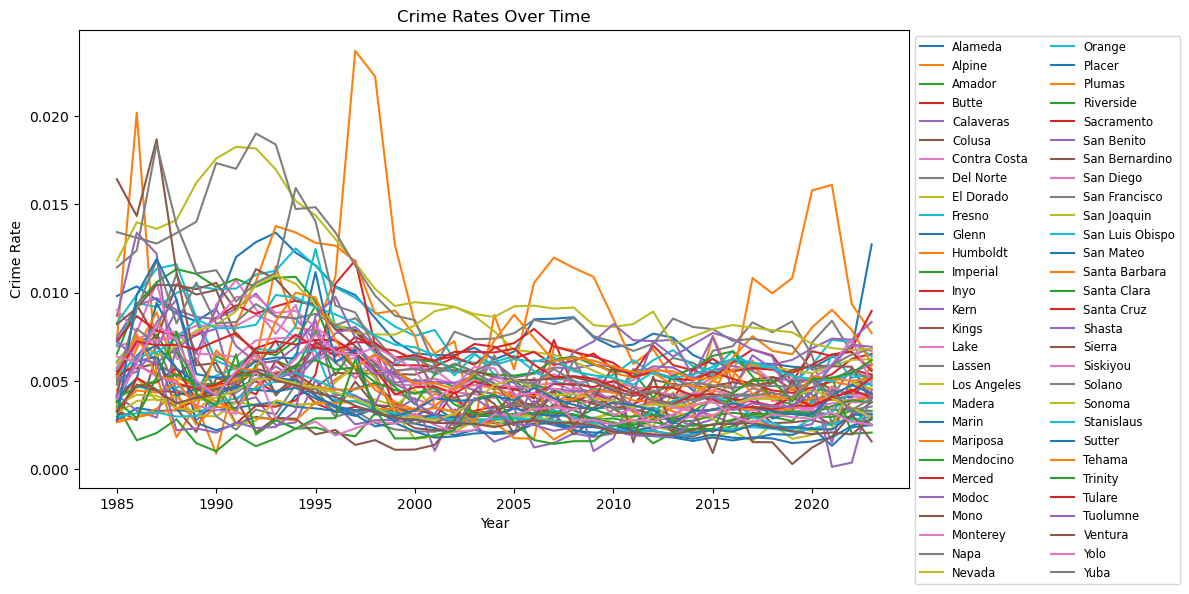

In [20]:
plt.figure(figsize=(12, 6))
for county in tseries_df["County"].unique():
    county_data = tseries_df[tseries_df["County"] == county]
    plt.plot(county_data["Year"], county_data["crime_rate"], label=county)

plt.title("Crime Rates Over Time")
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.legend(
    loc="upper left",  # Position the legend outside the plot
    bbox_to_anchor=(1, 1),  # Adjust position relative to the axes
    fontsize="small",  # Reduce font size
    ncol=2,  # Split legend into 2 columns
)

# Adjust layout to ensure everything fits
plt.tight_layout()
plt.show()

### Split into train and test

In [21]:
train_upto = 2012

# First step
train_data = tseries_df[tseries_df["Year"] <= train_upto]
test_data = tseries_df[tseries_df["Year"] > train_upto]
test_years = test_data["Year"].unique()
test_data_len = test_data["Year"].unique().__len__()

In [22]:
test_data_len

11

### Autoregressive Integrated Moving Average (ARIMA)
1. Test for stationarity
2. If the series isn’t stationary, difference it
3. Fit an ARIMA model for each county:

#### Test for stationarity. Resolve by differencing if not stationary

In [ ]:
def process_stationarity_and_differencing(df, column, county_col):
    """
    Test stationarity for each county and apply differencing to non-stationary counties.

    Args:
        df (pd.DataFrame): The input DataFrame with time series data.
        column (str): The column containing the time series data (e.g., 'crime_rate').
        county_col (str): The column containing county names.

    Returns:
        pd.DataFrame: Transformed DataFrame with differenced data for non-stationary counties.
        pd.DataFrame: Results of the ADF test (stationarity check).
    """
    results = []
    transformed_data = pd.DataFrame()

    counties = df[county_col].unique()

    for county in counties:
        county_data = df[df[county_col] == county][[column, "Year"]]
        county_data = county_data.dropna()
        adf_result = adfuller(county_data[column])
        is_stationary = adf_result[1] < 0.05  # p-value < 0.05 indicates stationarity

        results.append(
            {
                "County": county,
                "ADF Statistic": adf_result[0],
                "p-value": adf_result[1],
                "Stationary": is_stationary,
            }
        )

        # Apply differencing if non-stationary
        if not is_stationary:
            county_data[column] = county_data[column].diff().dropna()

        # Append the transformed (or untransformed) data back
        county_data[county_col] = county
        transformed_data = pd.concat([transformed_data, county_data])

    return transformed_data.reset_index(drop=True), pd.DataFrame(results)

#### Fit ARIMA model by county

In [24]:
def fit_arima_by_county(df, column, county_col, order=(1, 1, 1)):
    """
    Fit ARIMA models for each county, using the prepared (stationary) data.

    Args:
        df (pd.DataFrame): The input DataFrame with transformed time series data.
        column (str): The column containing the time series data (e.g., 'crime_rate').
        county_col (str): The column containing county names.
        order (tuple): ARIMA order (p, d, q).

    Returns:
        dict: A dictionary of ARIMA models fitted for each county.
    """
    arima_models = {}
    counties = df[county_col].unique()

    for county in counties:
        county_data = df[df[county_col] == county][column].dropna()

        if len(county_data) > max(order):  # Ensure enough data for ARIMA lags
            try:
                model = ARIMA(county_data, order=order)
                fitted_model = model.fit()
                arima_models[county] = fitted_model
                # print(f"ARIMA for {county} fitted successfully.")
            except Exception as e:
                print(f"ARIMA fitting failed for {county}: {e}")
        else:
            print(f"Insufficient data for ARIMA fitting in {county}.")

    return arima_models

In [25]:
# Step 1: Test stationarity and apply differencing where necessary
transformed_df, stationarity_results = process_stationarity_and_differencing(
    train_data, column="crime_rate", county_col="County"
)
# print(stationarity_results)

# Step 2: Fit ARIMA models
arima_models = fit_arima_by_county(
    transformed_df, column="crime_rate", county_col="County", order=(1, 1, 1)
)

#### Forcasts for ARIMA model

In [26]:
def forecast_arima_by_county(arima_models, steps=1):
    """
    Forecast future crime rates for all counties using ARIMA models.

    Args:
        arima_models (dict): Dictionary of fitted ARIMA models for each county.
        steps (int): Number of future time steps to forecast.

    Returns:
        dict: Forecasted crime rates for each county.
    """
    forecasts = {}

    for county, model in arima_models.items():
        try:
            forecast = model.forecast(steps=steps)
            forecasts[county] = forecast.tolist()  # Convert to list for readability
            # print(f"Forecast for {county}: {forecast}")
        except Exception as e:
            print(f"Forecasting failed for {county}: {e}")

    return forecasts


# Forecast for the next 3 years
arima_forecasts = forecast_arima_by_county(arima_models, steps=test_data_len)

In [27]:
arima_forecasts

{'Alameda': [0.0004918300840595739,
  0.00047951337095218194,
  0.00047831751837730833,
  0.00047820141082748047,
  0.0004781901377296001,
  0.0004781890432035679,
  0.0004781889369340005,
  0.0004781889266160906,
  0.0004781889256143056,
  0.0004781889255170404,
  0.0004781889255075967],
 'Alpine': [0.007762646966147275,
  0.008203037935078341,
  0.008405078748873604,
  0.008497770228306374,
  0.008540294855870694,
  0.008559804135046627,
  0.008568754524403683,
  0.008572860748366162,
  0.008574744585432618,
  0.008575608844694991,
  0.008576005346115363],
 'Amador': [-0.0001293792825763616,
  0.0002883522267622569,
  0.0001093708023003297,
  0.00018605726139253357,
  0.0001532001477240075,
  0.00016727812095952224,
  0.00016124626641443737,
  0.0001638306774403993,
  0.00016272335956640379,
  0.00016319780146506176,
  0.0001629945218824881],
 'Butte': [-0.00031603631404110075,
  -9.601123099818934e-05,
  -0.00015755599284903975,
  -0.00014034087510476345,
  -0.00014515623664060798,


#### Visualize forcasts for ARIMA model

In [28]:
def plot_arima_forecast_with_subplots(forecasts, start_year, group_size=10):
    """
    Plot ARIMA forecasted crime rates for counties as subplots, divided into groups.

    Args:
        forecasts (dict): Forecasted values for each county.
        start_year (int): Starting year for the forecast (e.g., 2024).
        group_size (int): Number of counties per group in each subplot.
    """
    # Split counties into groups
    counties = list(forecasts.keys())
    county_groups = [
        counties[i : i + group_size] for i in range(0, len(counties), group_size)
    ]

    num_groups = len(county_groups)
    rows = int((num_groups**0.5) + 0.5)  # Calculate rows for grid
    cols = int((num_groups / rows) + 0.5)  # Calculate columns for grid

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes for easier indexing

    for i, group in enumerate(county_groups):
        ax = axes[i]

        for county in group:
            forecast_years = list(
                range(start_year, start_year + len(forecasts[county]))
            )
            ax.plot(forecast_years, forecasts[county], label=county, marker="o")

        ax.set_title(f"Counties Group {i + 1}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Crime Rate")
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
        ax.grid(True)

    # Remove empty subplots (if groups < rows * cols)
    for j in range(len(county_groups), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

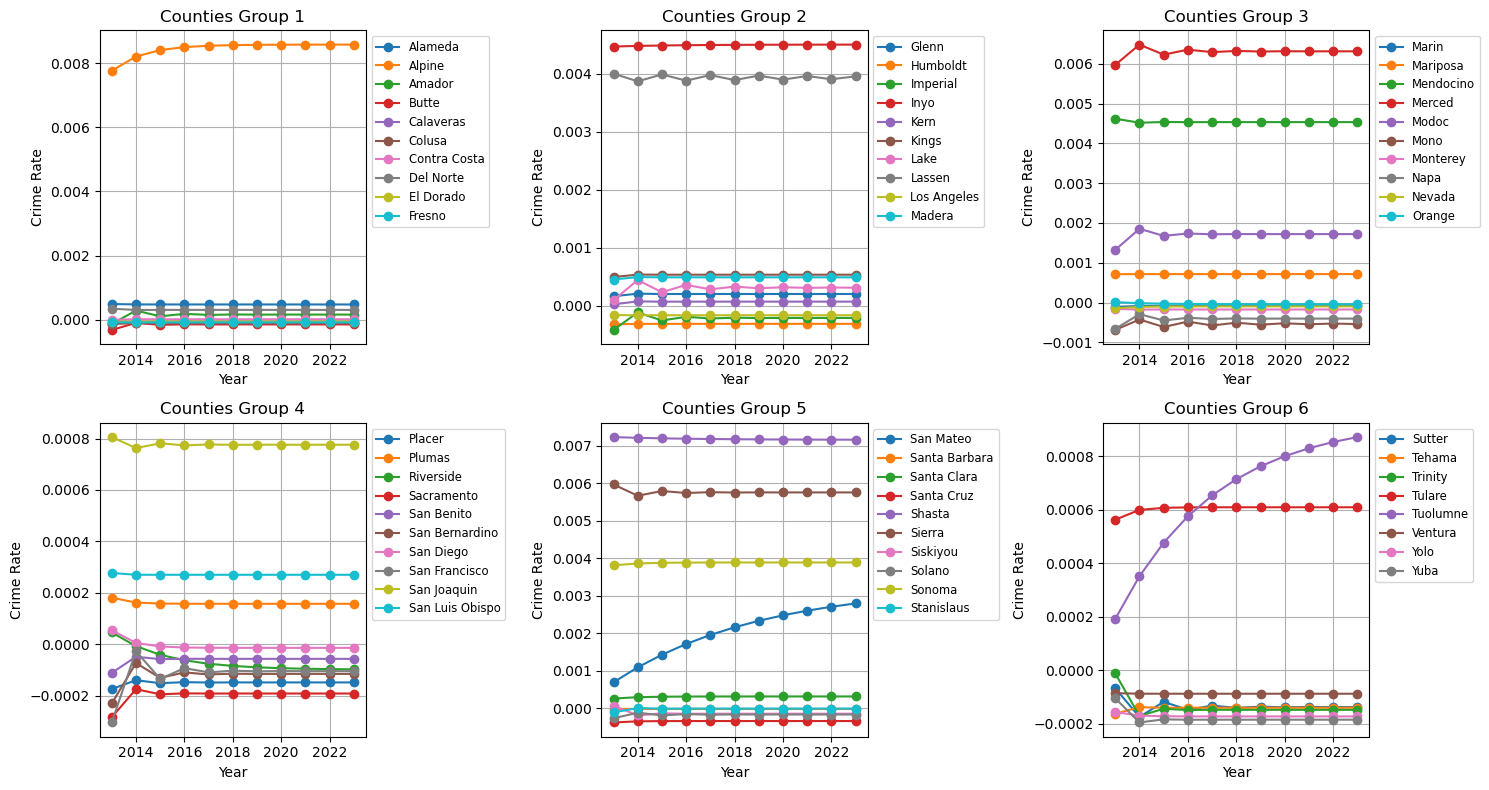

In [29]:
# Step 2: Plot forecasts using subplots
predict_years = test_data["Year"].unique()
start_year = predict_years[0]
plot_arima_forecast_with_subplots(arima_forecasts, start_year=start_year, group_size=10)

#### Predict backwards using ARIMA model

In [31]:
def filter_actual_values(
    df,
    start_year,
    end_year,
    county_col="County",
    value_col="crime_rate",
    year_col="Year",
):
    """
    Filter actual values for a specified time range and group by county.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        start_year (int): The starting year of the time range.
        end_year (int): The ending year of the time range.
        county_col (str): The column name for counties.
        value_col (str): The column name for the values (e.g., 'crime_rate').
        year_col (str): The column name for years.

    Returns:
        dict: A dictionary with counties as keys and lists of values as their data.
    """
    # Filter the DataFrame for the specified time range
    filtered_df = df[(df[year_col] >= start_year) & (df[year_col] <= end_year)]

    # Group by county and collect values into a dictionary
    grouped_values = filtered_df.groupby(county_col)[value_col].apply(list).to_dict()

    return grouped_values

In [32]:
# Filter actual values for 2020–2022
start_year = test_years[0]
end_year = test_years[-1]
actual_data = filter_actual_values(
    df=tseries_df, start_year=start_year, end_year=end_year
)

## Evaluations for the predictions

In [33]:
def evaluate_arima_predictions(actual, predicted):
    """
    Evaluate ARIMA predictions using MAE, MSE, RMSE, and MAPE.

    Args:
        actual (list): Actual observed values.
        predicted (list): Predicted values from the ARIMA model.

    Returns:
        dict: Evaluation metrics (MAE, MSE, RMSE, MAPE).
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = root_mean_squared_error(
        actual, predicted
    )  # mse ** 0.5 Root mean squared error

    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


# Example Usage
actual_values_example = [50, 52, 54]  # Replace with actual data
predicted_values_example = [49, 53, 55]  # Replace with ARIMA predictions

evaluation_results = evaluate_arima_predictions(
    actual_values_example, predicted_values_example
)
print("Evaluation Metrics:", evaluation_results)

Evaluation Metrics: {'MAE': 1.0, 'MSE': 1.0, 'RMSE': 1.0}


In [34]:
def evaluate_forecast_counties(actual_dict, predicted_dict):
    """
    Evaluate ARIMA predictions for multiple counties.

    Args:
        actual_dict (dict): Dictionary of actual values per county.
        predicted_dict (dict): Dictionary of predicted values per county.

    Returns:
        dict: Evaluation metrics per county.
    """
    evaluation_results = {}

    for county in actual_dict.keys():
        if county in predicted_dict:
            actual = actual_dict[county]
            predicted = predicted_dict[county]
            evaluation_results[county] = evaluate_arima_predictions(actual, predicted)
        else:
            print(f"Predictions missing for {county}")

    return evaluation_results

In [35]:
evaluation_results = evaluate_forecast_counties(actual_data, arima_forecasts)

In [36]:
#### Visualise evaluation metrics for ARIMA

In [37]:
def plot_metrics(evaluation_results):
    """
    Plot evaluation metrics as vertical bar charts with county names rotated 90 degrees directly under the bars.

    Args:
        evaluation_results (dict): Dictionary with counties as keys and evaluation metrics as values.
    """
    # Extract counties and metrics
    counties = list(evaluation_results.keys())
    metrics = ["MAE", "MSE", "RMSE"]

    # Initialize data arrays for metrics
    metric_values = {
        metric: [evaluation_results[county][metric] for county in counties]
        for metric in metrics
    }

    # Plot each metric as a vertical bar chart
    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Bar chart for the current metric
        x_positions = np.arange(len(counties))  # X-axis positions for bars
        plt.bar(x_positions, metric_values[metric], color="skyblue", width=0.6)

        # Add labels and title
        plt.title(f"{metric} Across Counties", fontsize=14)
        plt.xlabel("Counties", fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.xticks(
            x_positions, counties, rotation=90, ha="center"
        )  # Rotate labels 90 degrees, center aligned
        plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add horizontal grid lines

        # Ensure spacing for rotated labels
        plt.tight_layout()
        plt.show()

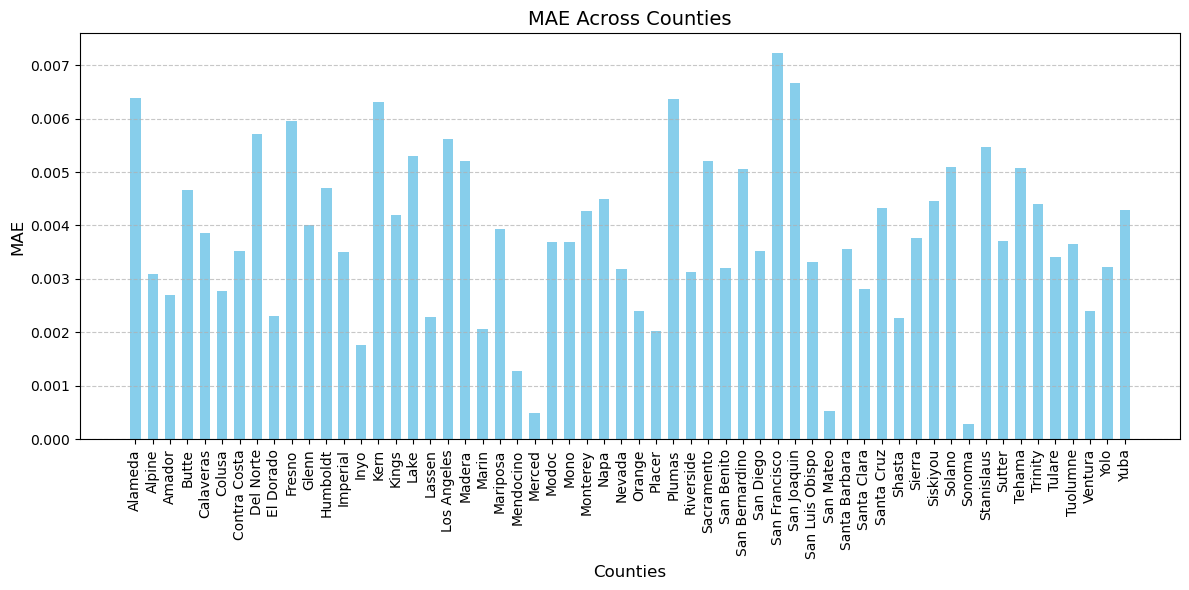

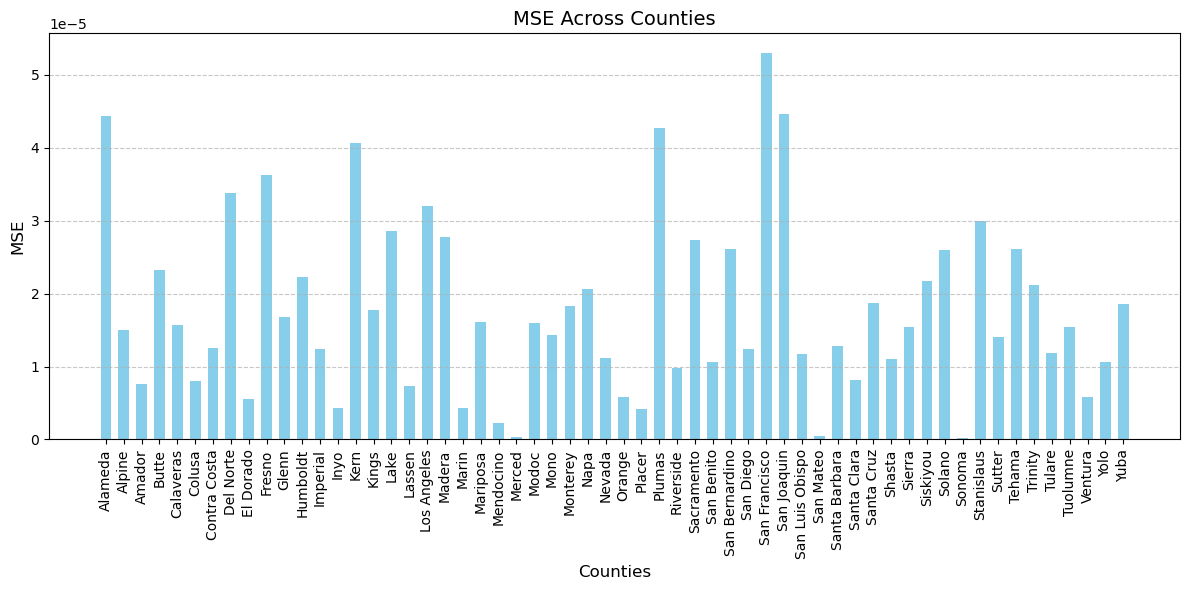

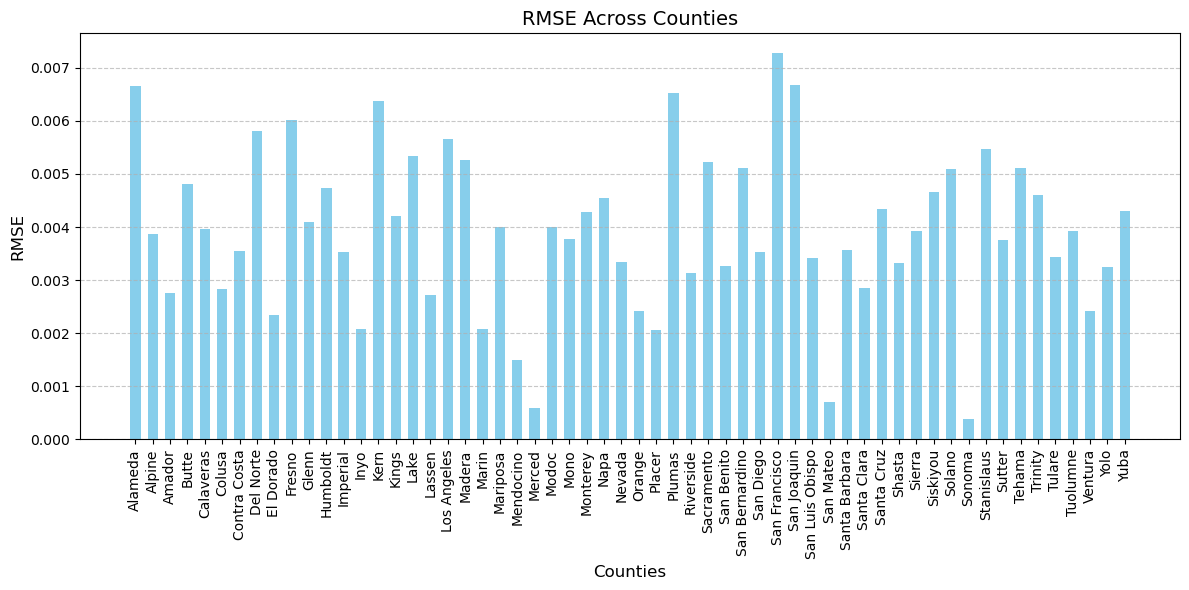

In [38]:
# Plot separate charts for each metric
plot_metrics(evaluation_results)

### Vector Autoregression (VAR)

In [39]:
def prepare_lagged_features(df, column, county_col, max_lag=2):
    """
    Prepare lagged features for each county.

    Args:
        df (pd.DataFrame): Original DataFrame with time series data.
        column (str): Column containing the primary time series data (e.g., 'crime_rate').
        county_col (str): Column containing county identifiers.
        max_lag (int): Maximum lag to include in the lagged features.

    Returns:
        pd.DataFrame: DataFrame with lagged features included.
    """
    lagged_data = pd.DataFrame()

    # Create lagged features per county
    for county in df[county_col].unique():
        county_data = df[df[county_col] == county].sort_values(by="Year")
        for lag in range(1, max_lag + 1):
            county_data[f"{column}_lag{lag}"] = county_data[column].shift(lag)

        lagged_data = pd.concat([lagged_data, county_data])

    # Drop rows with NaNs (lagging introduces NaNs for the first 'max_lag' rows)
    return lagged_data.dropna().reset_index(drop=True)

In [40]:
def prepare_var_data(df, features, county_col):
    """
    Prepare VAR-ready data by dropping constant columns.

    Args:
        df (pd.DataFrame): DataFrame with features and counties.
        features (list): List of feature columns to include.
        county_col (str): Column containing county identifiers.

    Returns:
        dict: Dictionary of cleaned DataFrames, one per county.
    """
    var_ready_data = {}
    counties = df[county_col].unique()

    for county in counties:
        county_data = df[df[county_col] == county][features]

        # Drop constant columns
        constant_columns = [
            col for col in county_data.columns if county_data[col].nunique() == 1
        ]
        if constant_columns:
            print(f"Dropping constant columns for {county}: {constant_columns}")
            county_data = county_data.drop(columns=constant_columns)

        var_ready_data[county] = county_data

    return var_ready_data

In [41]:
def fit_var_by_county(var_ready_data, max_lag=2):
    """
    Fit VAR models for each county.

    Args:
        var_ready_data (dict): Dictionary of DataFrames with lagged features for each county.
        max_lag (int): Maximum lag length to consider for VAR.

    Returns:
        dict: Dictionary of fitted VAR models per county.
    """
    var_models = {}

    for county, data in var_ready_data.items():
        if len(data) > max_lag:
            try:
                model = VAR(data)
                fitted_model = model.fit(maxlags=max_lag)
                var_models[county] = fitted_model
                # print(f"VAR model fitted for {county}")
            except Exception as e:
                print(f"VAR fitting failed for {county}: {e}")
        else:
            print(f"Insufficient data for VAR fitting in {county}")

    return var_models

In [42]:
def forecast_var_by_county(var_models, var_ready_data, steps=1):
    """
    Forecast future values using VAR models.

    Args:
        var_models (dict): Dictionary of fitted VAR models.
        var_ready_data (dict): Dictionary of DataFrames for each county (for latest observations).
        steps (int): Number of future time steps to forecast.

    Returns:
        dict: Forecasted values for each county.
    """
    forecasts = {}

    for county, model in var_models.items():
        try:
            last_values = var_ready_data[county].values[
                -model.k_ar :
            ]  # Get last 'k_ar' observations
            forecast = model.forecast(y=last_values, steps=steps)
            forecasts[county] = forecast
            # print(f"Forecast for {county}: {forecast}")
        except Exception as e:
            print(f"Forecasting failed for {county}: {e}")

    return forecasts

In [43]:
# Step 1: Prepare lagged features
lagged_df = prepare_lagged_features(
    tseries_df, column="crime_rate", county_col="County", max_lag=2
)

In [44]:
lagged_df

,County,Year,crime_rate,Population,clearance_rate,population_density,mobile_home_ratio,poverty_rate,adjusted_income,unemployment_rate,...,welfare_budget_per_capita,mental_health_budget_per_capita,rehab_budget_per_capita,health_budget_per_capita,judiciary_budget_per_capita,prison_budget_per_capita,combined_adj_budgets,stress_factor,crime_rate_lag1,crime_rate_lag2
0,Alameda,1987,0.009588,1220600,0.005164,1653.929539,0.061794,14.975287,219.856018,7.85,...,444.159558,145.18625,21.365535,289.572716,118.757226,166.561466,5.695536e+07,17.57947,0.010353,0.009809
1,Alameda,1988,0.008825,1242300,0.004595,1683.333333,0.061794,14.975287,219.856018,7.85,...,444.159558,145.18625,21.365535,289.572716,118.757226,166.561466,5.695536e+07,17.57947,0.009588,0.010353
2,Alameda,1989,0.008375,1261200,0.004163,1708.943089,0.061794,14.975287,219.856018,7.85,...,444.159558,145.18625,21.365535,289.572716,118.757226,166.561466,5.695536e+07,17.57947,0.008825,0.009588
3,Alameda,1990,0.009106,1276702,0.004281,1729.948509,0.061794,14.975287,219.856018,7.85,...,444.159558,145.18625,21.365535,289.572716,118.757226,166.561466,5.695536e+07,17.57947,0.008375,0.008825
4,Alameda,1991,0.012014,1284782,0.004647,1740.897019,0.061794,14.975287,219.856018,5.50,...,444.159558,145.18625,21.365535,289.572716,118.757226,166.561466,5.695536e+07,17.57947,0.009106,0.008375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2141,Yuba,2019,0.004095,79619,0.001683,126.379365,0.082943,15.200000,201.708250,6.20,...,695.612065,145.18625,21.365535,92.845765,97.991535,362.065098,5.695536e+07,15.96000,0.004330,0.004180
2142,Yuba,2020,0.004977,81178,0.001983,128.853968,0.093497,16.300000,197.248655,10.60,...,752.918722,145.18625,21.365535,99.150225,103.327342,364.688807,5.695536e+07,17.69000,0.004095,0.004330
2143,Yuba,2021,0.004312,82091,0.001815,130.303175,0.087198,15.600000,204.337343,8.40,...,752.387765,145.18625,21.365535,109.459746,96.746623,397.943648,5.695536e+07,16.74000,0.004977,0.004095
2144,Yuba,2022,0.003379,82563,0.001466,131.052381,0.083845,14.900000,199.314588,5.60,...,784.468854,145.18625,21.365535,98.960176,97.368240,417.975146,5.695536e+07,15.17000,0.004312,0.004977


#### Split data for VAR

In [45]:
var_train_upto = 2012

# First step
var_train_data = lagged_df[lagged_df["Year"] <= var_train_upto]
var_test_data = lagged_df[lagged_df["Year"] > var_train_upto]
var_test_years = test_data["Year"].unique()
var_test_data_len = var_test_data["Year"].unique().__len__()

In [46]:
# Step 2: Prepare VAR-ready data
features = ["crime_rate", "crime_rate_lag1", "crime_rate_lag2"]
var_ready_data = prepare_var_data(
    var_train_data, features=features, county_col="County"
)
var_ready_data

{'Alameda':     crime_rate  crime_rate_lag1  crime_rate_lag2
 0     0.009588         0.010353         0.009809
 1     0.008825         0.009588         0.010353
 2     0.008375         0.008825         0.009588
 3     0.009106         0.008375         0.008825
 4     0.012014         0.009106         0.008375
 5     0.012856         0.012014         0.009106
 6     0.013388         0.012856         0.012014
 7     0.012262         0.013388         0.012856
 8     0.011547         0.012262         0.013388
 9     0.010351         0.011547         0.012262
 10    0.009864         0.010351         0.011547
 11    0.008563         0.009864         0.010351
 12    0.007246         0.008563         0.009864
 13    0.006569         0.007246         0.008563
 14    0.006466         0.006569         0.007246
 15    0.006473         0.006466         0.006569
 16    0.006883         0.006473         0.006466
 17    0.006215         0.006883         0.006473
 18    0.006665         0.006215       

In [47]:
# Step 3: Fit VAR models
var_models = fit_var_by_county(var_ready_data, max_lag=2)

# Step 4: Forecast future crime rates
var_forecasts = forecast_var_by_county(
    var_models, var_ready_data, steps=var_test_data_len
)

In [48]:
var_test_data_len

11

In [49]:
# Function to extract main forecast (e.g., crime_rate) from the forecast matrix
def extract_forecast(forecasts, variable_index=0):
    """
    Extract the main variable forecast (e.g., crime_rate) for each county.

    Args:
        forecasts (dict): Dictionary of forecast matrices per county.
        variable_index (int): Index of the target variable to extract (e.g., 0 for crime_rate).

    Returns:
        dict: Simplified forecasted values for each county.
    """
    simplified_forecasts = {}
    for county, forecast_matrix in forecasts.items():
        simplified_forecasts[county] = forecast_matrix[:, variable_index].tolist()
    return simplified_forecasts

In [50]:
# Extract the forecasted crime rates
simplified_forecasts = extract_forecast(var_forecasts, variable_index=0)
simplified_forecasts

{'Alameda': [0.008261571867492767,
  0.008653482966775747,
  0.008789746981681489,
  0.008769354655286056,
  0.008687833712671802,
  0.008625808140634841,
  0.008609354520818697,
  0.008633197465952619,
  0.008674599483985513,
  0.00871369219247545,
  0.008739619445936594],
 'Alpine': [0.007892297019089506,
  0.009061070408668352,
  0.009819922591731076,
  0.010051021558948707,
  0.00992794193244582,
  0.009653103010603105,
  0.009397457252729457,
  0.009246224422265035,
  0.009206802047077344,
  0.009242474228395182,
  0.009305731871543935],
 'Amador': [0.0031590958713191303,
  0.0032275765556577284,
  0.003192956612846423,
  0.003110037724345049,
  0.003087645049316016,
  0.0030438451458628373,
  0.0030166672549315544,
  0.0029970224442432574,
  0.002980364867096893,
  0.0029697447608455505,
  0.0029616560626835337],
 'Butte': [0.003043674086055333,
  0.0032173631140258395,
  0.003365632986817746,
  0.0034528033458092605,
  0.0035302152066493475,
  0.0035744275118470142,
  0.00360122

In [51]:
def plot_forecast_with_years(simplified_forecasts, start_year):
    """
    Plot forecasted crime rates for each county with actual years on the x-axis.

    Args:
        simplified_forecasts (dict): Forecasted values for each county.
        start_year (int): The starting year for the forecast (e.g., 2024).
    """
    plt.figure(figsize=(12, 6))
    for county, crime_rates in simplified_forecasts.items():
        forecast_years = list(
            range(start_year, start_year + len(crime_rates))
        )  # Create future years
        plt.plot(
            forecast_years, crime_rates, label=county, marker="o"
        )  # Plot with years as x-axis

    plt.title("Forecasted Crime Rates by Year")
    plt.xlabel("Year")
    plt.ylabel("Crime Rate")
    plt.legend(
        loc="upper left",  # Position the legend outside the plot
        bbox_to_anchor=(1, 1),  # Adjust position relative to the axes
        fontsize="small",  # Reduce font size
        ncol=2,  # Split legend into 2 columns
    )
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    plt.grid(True)
    plt.show()

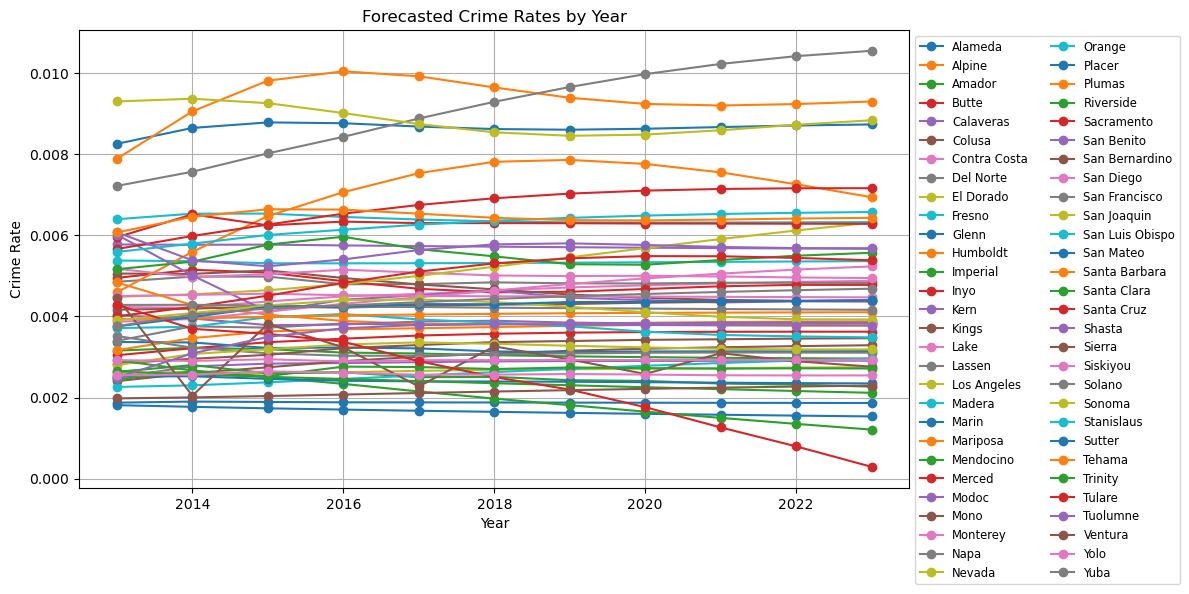

In [52]:
var_start_year = var_test_years[0]

# Start forecasting from 2024
plot_forecast_with_years(simplified_forecasts, start_year=var_start_year)

In [53]:
def plot_forecast_with_subplots(simplified_forecasts, start_year, group_size=10):
    """
    Plot forecasted crime rates for counties as subplots, divided into groups.

    Args:
        simplified_forecasts (dict): Forecasted values for each county.
        start_year (int): Starting year for the forecast (e.g., 2024).
        group_size (int): Number of counties per group in each subplot.
    """
    # Split counties into groups
    counties = list(simplified_forecasts.keys())
    county_groups = [
        counties[i : i + group_size] for i in range(0, len(counties), group_size)
    ]

    num_groups = len(county_groups)
    rows = int((num_groups**0.5) + 0.5)  # Calculate rows for grid
    cols = int((num_groups / rows) + 0.5)  # Calculate columns for grid

    # palette = sns.color_palette("husl", len(counties))  # Generate unique colors
    # color_mapping = {county: palette[i % len(palette)] for i, county in enumerate(counties)}

    # Use a visually distinct Matplotlib palette (e.g., tab20)
    colors = plt.cm.tab20.colors  # Predefined palette with 20 distinct colors
    color_mapping = {
        county: colors[i % len(colors)] for i, county in enumerate(counties)
    }

    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, group in enumerate(county_groups):
        ax = axes[i]

        for county in group:
            forecast_years = list(
                range(start_year, start_year + len(simplified_forecasts[county]))
            )
            ax.plot(
                forecast_years,
                simplified_forecasts[county],
                label=county,
                marker="o",
                color=color_mapping[county],
            )
        # print(forecast_years)
        ax.set_title(f"Counties Group {i + 1}")
        ax.set_xlabel("Year")
        ax.set_ylabel("Crime Rate")
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
        ax.grid(True)

    # Remove empty subplots (if groups < rows * cols)
    for j in range(len(county_groups), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

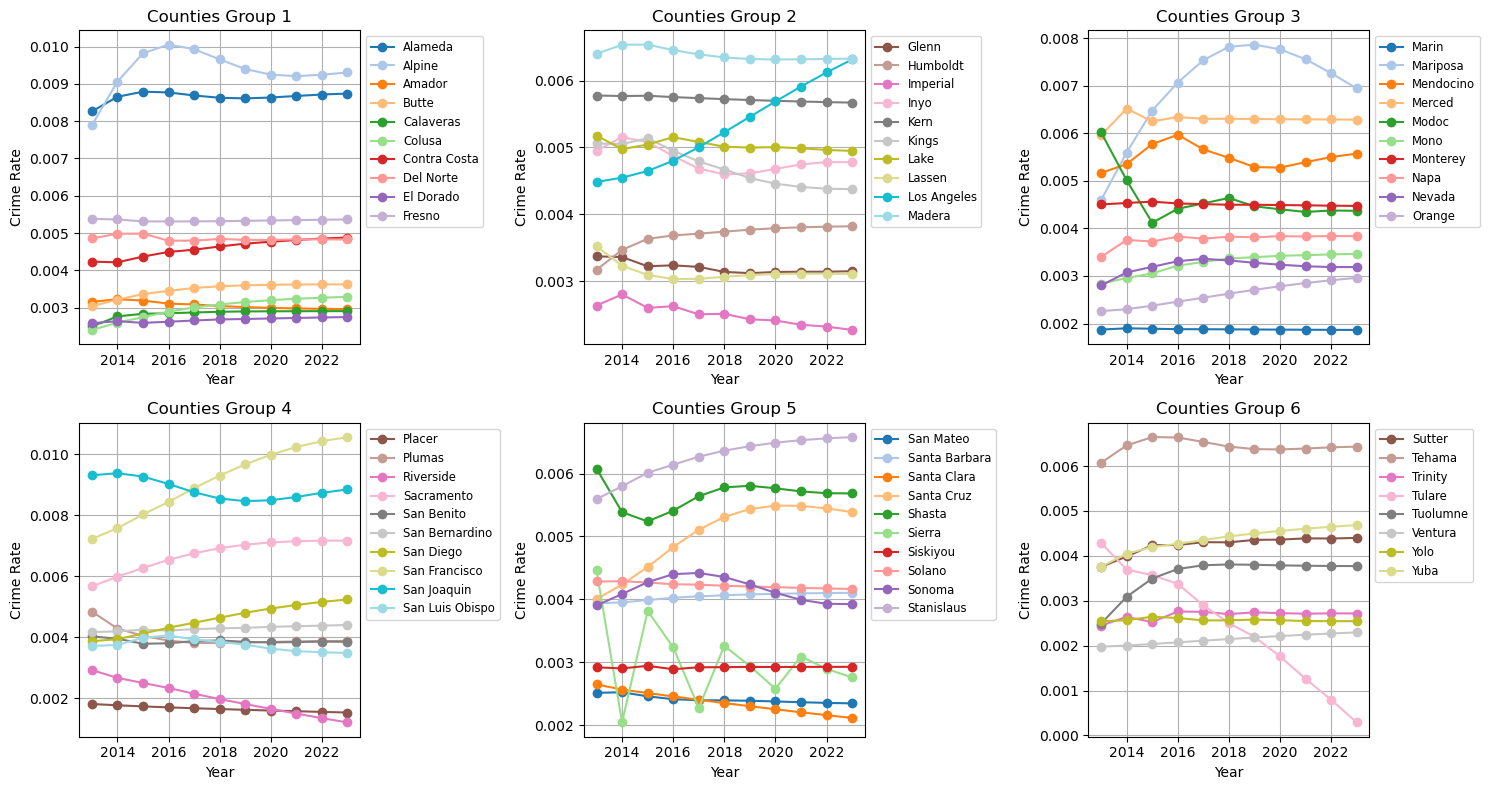

In [54]:
# Start forecasting from 2024
plot_forecast_with_subplots(
    simplified_forecasts, start_year=var_start_year, group_size=10
)

#### Evaluate forecast for VAR

In [55]:
# Filter actual values for 2020–2022
var_start_year = var_test_years[0]
var_end_year = var_test_years[-1]
var_actual_data = filter_actual_values(
    df=tseries_df, start_year=var_start_year, end_year=var_end_year
)

In [56]:
var_evaluation_results = evaluate_forecast_counties(
    var_actual_data, simplified_forecasts
)

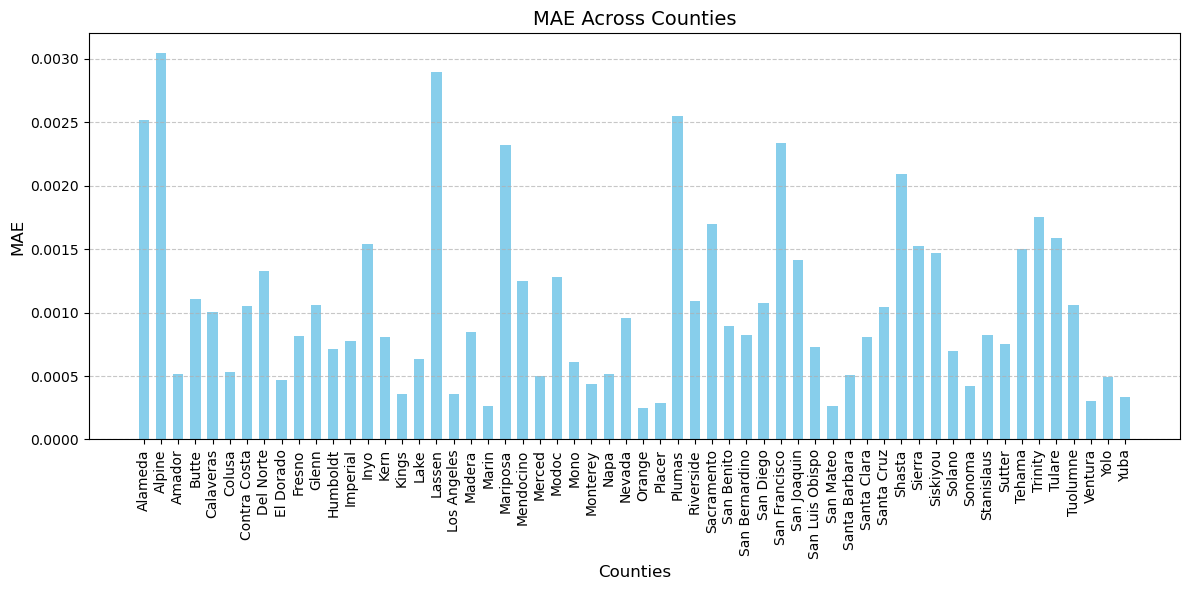

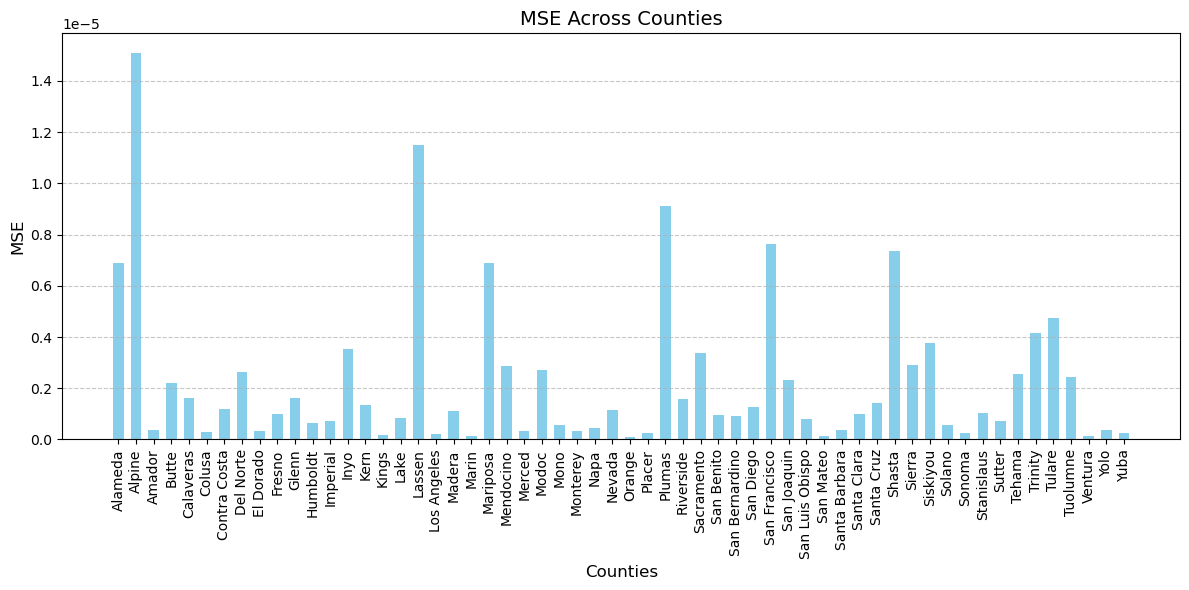

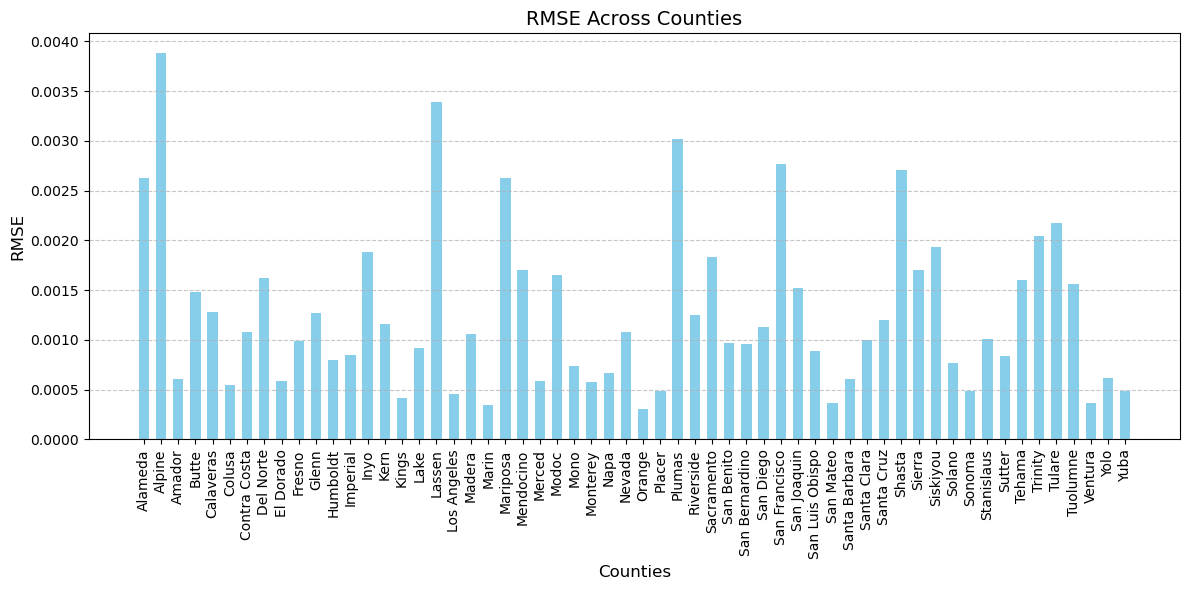

In [57]:
plot_metrics(var_evaluation_results)